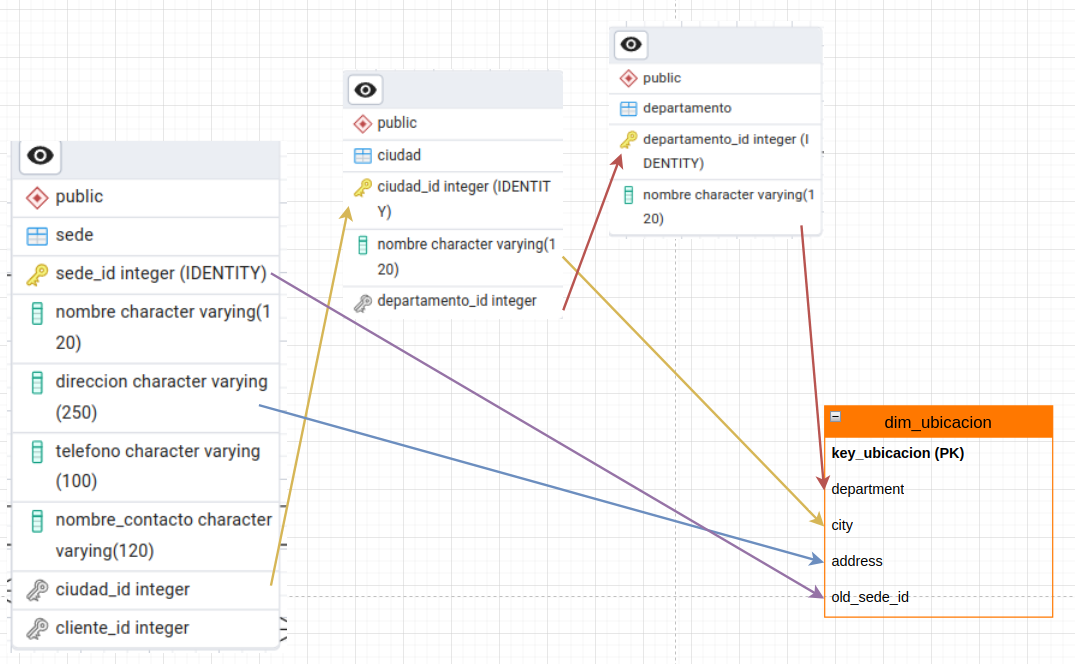

## Importar librerías

In [ ]:
# Importar las librerias
import pandas as pd  # Para manipular datos
import sqlalchemy as sa  # Para conectar a la base de datos
import utils.conn_tools as ct  # Para leer la configuración de conexión

## Conexión con base de datos

In [ ]:
config = ct.readConfig("../config/config-postgres.yaml")

config_src = config["source"]
config_etl = config["warehouse"]

engine_src = sa.create_engine(ct.generateConnUrl(config_src))
engine_etl = sa.create_engine(ct.generateConnUrl(config_etl))

## Extract

In [ ]:
# Leer los datos de las tablas
sede_df = pd.read_sql_table("sede", con=engine_src)
ciudad_df = pd.read_sql_table("ciudad", con=engine_src)
departamento_df = pd.read_sql_table("departamento", con=engine_src)

In [ ]:
# Comprobar los campos
sede_df.info()

In [ ]:
# Comprobar los campos
ciudad_df.info()

In [ ]:
# Comprobar los campos
departamento_df.info()

## Transform: Ajustes de la dimensión

### Realizar JOIN en función del campo ciudad_id entre sede y ciudad

In [ ]:
sede_ciudad_df = sede_df.merge(
    ciudad_df, left_on="ciudad_id", right_on="ciudad_id", suffixes=("_sede", "_ciudad")
)

sede_ciudad_df.head(3)

### Realizar JOIN en función del campo departamento_id entre ubicacion y sede_ciudad

In [ ]:
ubicacion_df = sede_ciudad_df.merge(
    departamento_df,
    left_on="departamento_id",
    right_on="departamento_id",
    suffixes=("_ciudad", "_departamento"),
)

ubicacion_df = ubicacion_df.rename(columns={"nombre": "nombre_departamento"})

ubicacion_df.head(3)

### Extraer solo los campos relevantes

In [ ]:
dim_ubicacion = pd.DataFrame(
    {
        "name_of_the_site": ubicacion_df["nombre_sede"].values,
        "department": ubicacion_df["nombre_departamento"].values,
        "city": ubicacion_df["nombre_ciudad"].values,
        "address": ubicacion_df["direccion"].values,
        "old_sede_id": ubicacion_df["sede_id"].values,
    }
)

dim_ubicacion.head(5)

In [ ]:
# Create table
metadata = sa.MetaData()

metadata.reflect(bind=engine_etl)  # Reflect helps to get existing tables

dim_ubicacion_table = sa.Table(
    "dim_ubicacion",
    metadata,
    # Primary key
    sa.Column("key_ubicacion", sa.Integer, primary_key=True, autoincrement=True),
    # Dimension keys
    sa.Column("name_of_the_site", sa.String, nullable=False),
    sa.Column("department", sa.String, nullable=False),
    sa.Column("city", sa.String, nullable=False),
    sa.Column("address", sa.String, nullable=False),
    sa.Column("old_sede_id", sa.Integer, nullable=False),
)

metadata.create_all(engine_etl)

## Load: Ejecución de ETL

In [ ]:
dim_ubicacion.to_sql(
    name="dim_ubicacion",
    con=engine_etl,
    if_exists="append",  # Create table if not exists, else append
    index=False,  # Do not create index because we already have one PK
)